#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import model_utils
import warnings
from importlib import reload

In [2]:
plt.style.use('./styles.txt')
warnings.filterwarnings('ignore')

#### Index

---
<a id='intro'></a>
# Introduction

So far our classification problem has been directed by the wildfire classifications given by the original data set. Our models have been significantly underperforming when trying to classify such a number of classes, with the additional difficulty of the wildfire sizes themselves varying massively. It could perhaps be more useful to simplify the classification problem by creating alternate bins which separate the fires into more distinguishable, from the perspective of the model, categories. 

---

## Analysing Wildfire Class Distribution

In the classification models that we have created so far wildfires have been separated into the following categories:

<table>
  <tr>
    <th style="text-align: left; background: lightgrey">Fire Size Class</th>
    <th style="text-align: left; background: lightgrey">Size</th>
  </tr>
  <tr>
    <td style="text-align: left"> <code>A</code> </td>
    <td style="text-align: left">0-0.25 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>B</code></td>
    <td style="text-align: left">0.26-9.99 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>C</code></td>
    <td style="text-align: left">10.0-99.9 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>D</code></td>
    <td style="text-align: left">100-299 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>E</code></td>
    <td style="text-align: left">300-999 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>F</code></td>
    <td style="text-align: left">1000-4999</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>G</code></td>
    <td style="text-align: left">5000+ acres</td>
  </tr>
</table>

Let us look at the distribution of our fires and see whether we can determine a better way to split the fires.

In [3]:
df = utils.LoadDf()

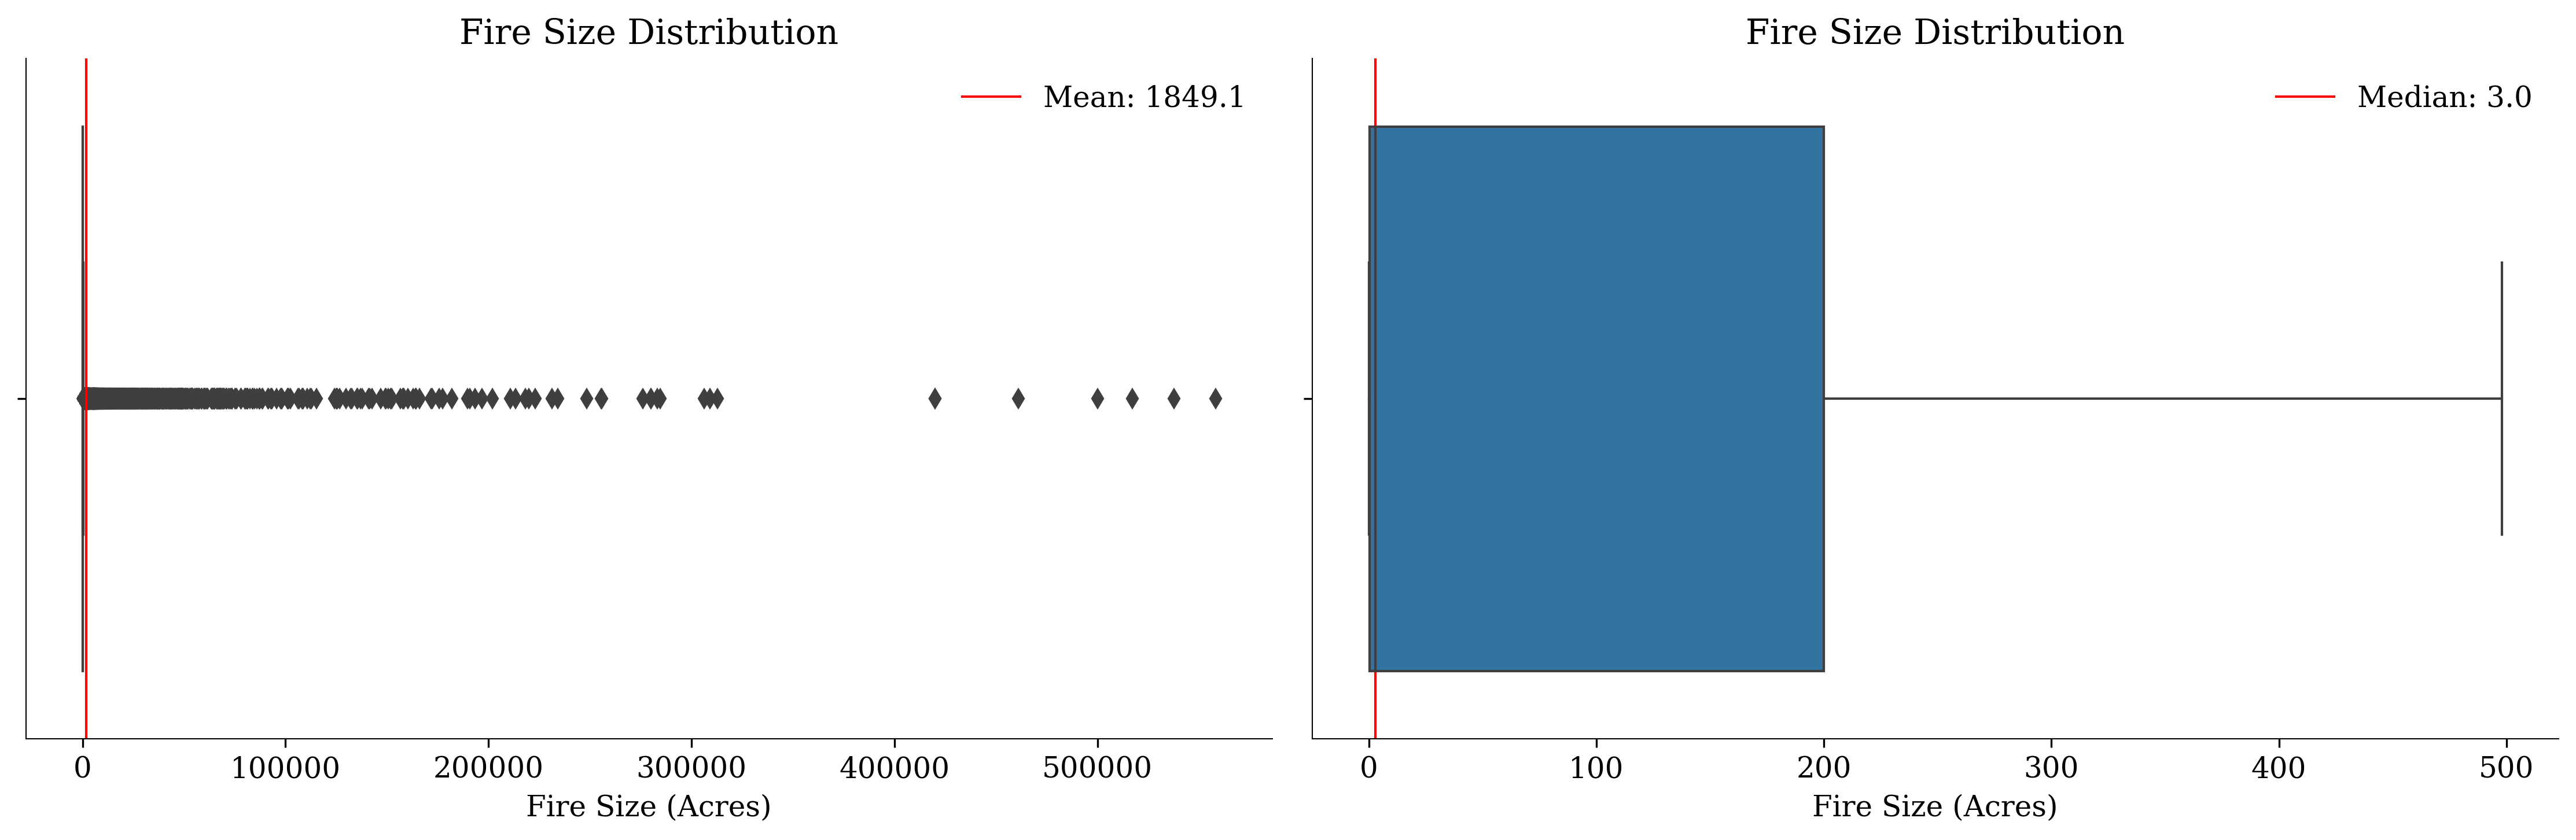

In [4]:
utils.PlotFireSizeDistribution(df)

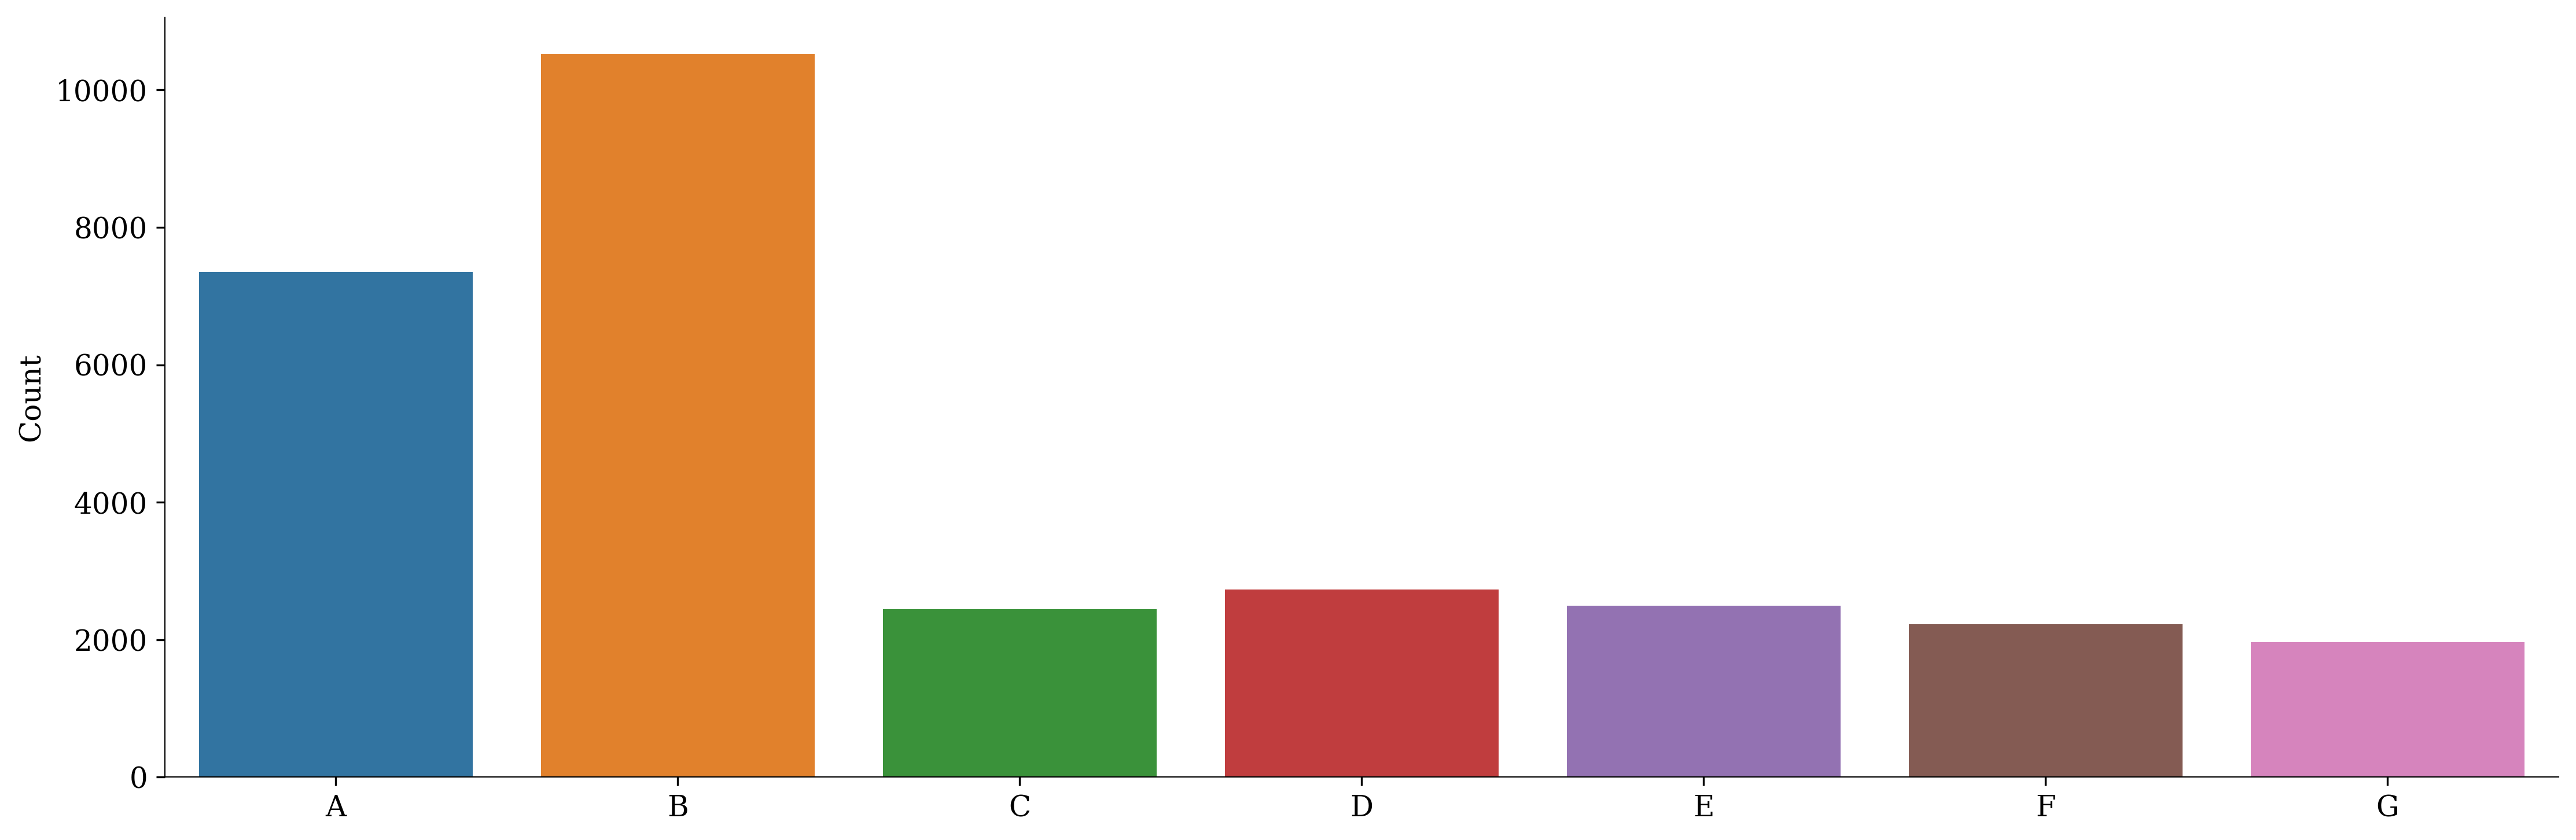

In [9]:
fire_size_df = utils.count_percentage_df(df['FIRE_SIZE_CLASS']).sort_index()

plt.figure(figsize=(15, 5))
sns.barplot(y='Count', x=fire_size_df.index, data=fire_size_df)
plt.show()

In [53]:
fig, axes = plt.subplots(4, 2, figsize=(30, 30))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

for idx, tpl in enumerate(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G'], colors)):
    fire_class, color = tpl
    tmp = df[df['FIRE_SIZE_CLASS'] == fire_class]
    plt.subplot(4, 2, idx + 1)
    plt.title(f'Fire Size Class {fire_class}')
    sns.boxplot(x=tmp['FIRE_SIZE'], color = color)
fig.delaxes(axes[3][1])
plt.show()

Given the vast distributions, we see that binning the fires into meaningful new bins is a challenging task in and of itself. Perhaps there is some other distinction that we should be able to make.

---

## Splitting the Data

According to the Northwest Interagency Coordination Centre, wildfires that are greater than 100 acres in size are considered large. It is these large wildfires that pose a greater risk to the environment, meaning that we could perhaps train a model to distinguish between a large and a small wildfire.

In [54]:
df['large_wildfire'] = df['FIRE_SIZE'].apply(lambda x: 1 if x >= 100 else 0)

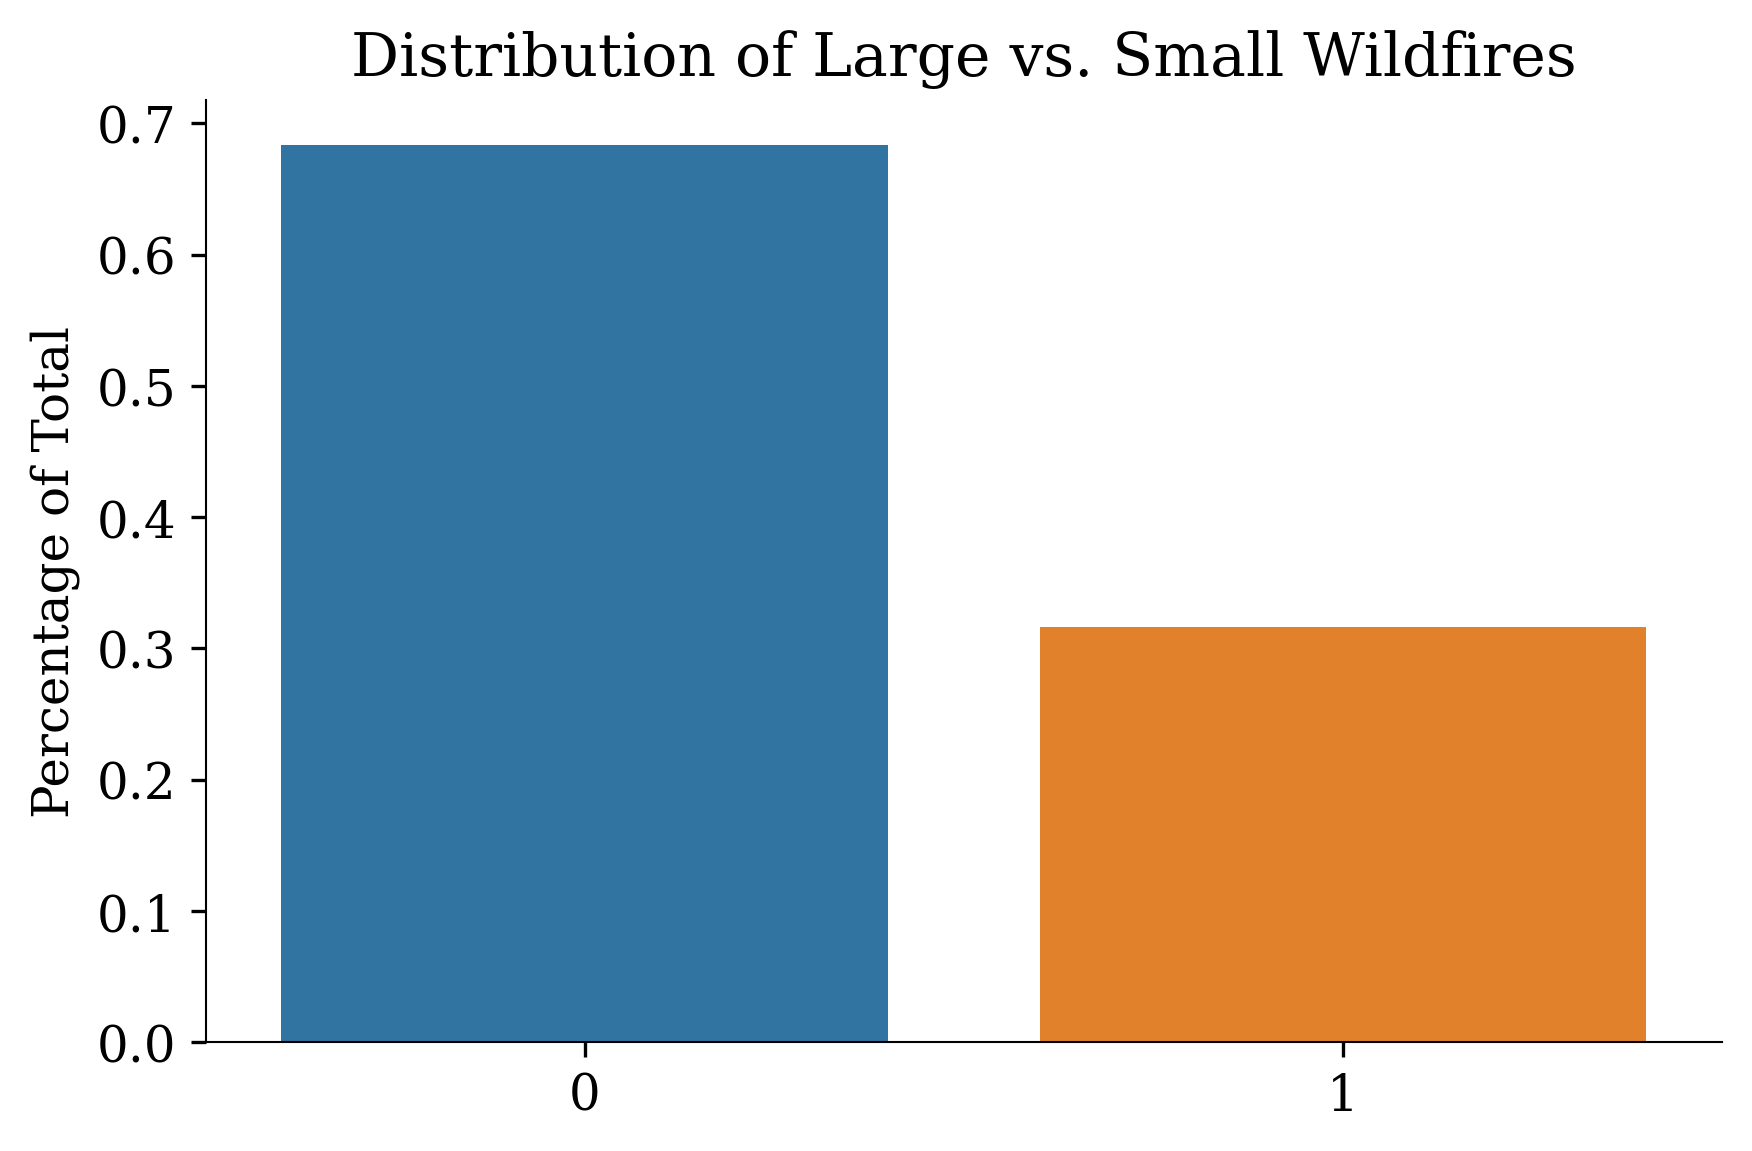

In [58]:
g = utils.count_percentage_df(df['large_wildfire'])
plt.figure()
plt.title('Distribution of Large vs. Small Wildfires')
sns.barplot(x=g.index, y='Percentage of Total', data=g)
plt.show()

Although this is still imbalances, we have created a meaningful separation in our wildfires while simultaneously simplifying the classification problem. We can now begin to model 

---
## Modelling

We will begin by building a number of logistic regression models, optimising these, followed by using an ensemble method to create the most accurate model. Before we do this however, we need to do the basic preprocessing of our variables, as we are going to be using logistic regression.

In [64]:
df_categorical_processed = utils.BasicCategoricalPreprocessing(df)
df_processed, _ = utils.BasicNumericPreprocessing(df_categorical_processed)
df_processed.shape

(29734, 86)

In [66]:
# Create a function that can generate X and y variables
def create_x_y(df):
    X = df.drop(['FIRE_SIZE', 'FIRE_SIZE_CLASS', 'large_wildfire'], axis=1)
    y = df['large_wildfire']
    
    return X, y

In [71]:
X, y = create_x_y(df_processed)

In [72]:
reload(model_utils);

In [73]:
X_train, X_test, y_train, y_test = model_utils.CreateTransformedTTS(X, y)

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(X_train, y_train)

logit.score(X_test, y_test)

0.7476038338658147

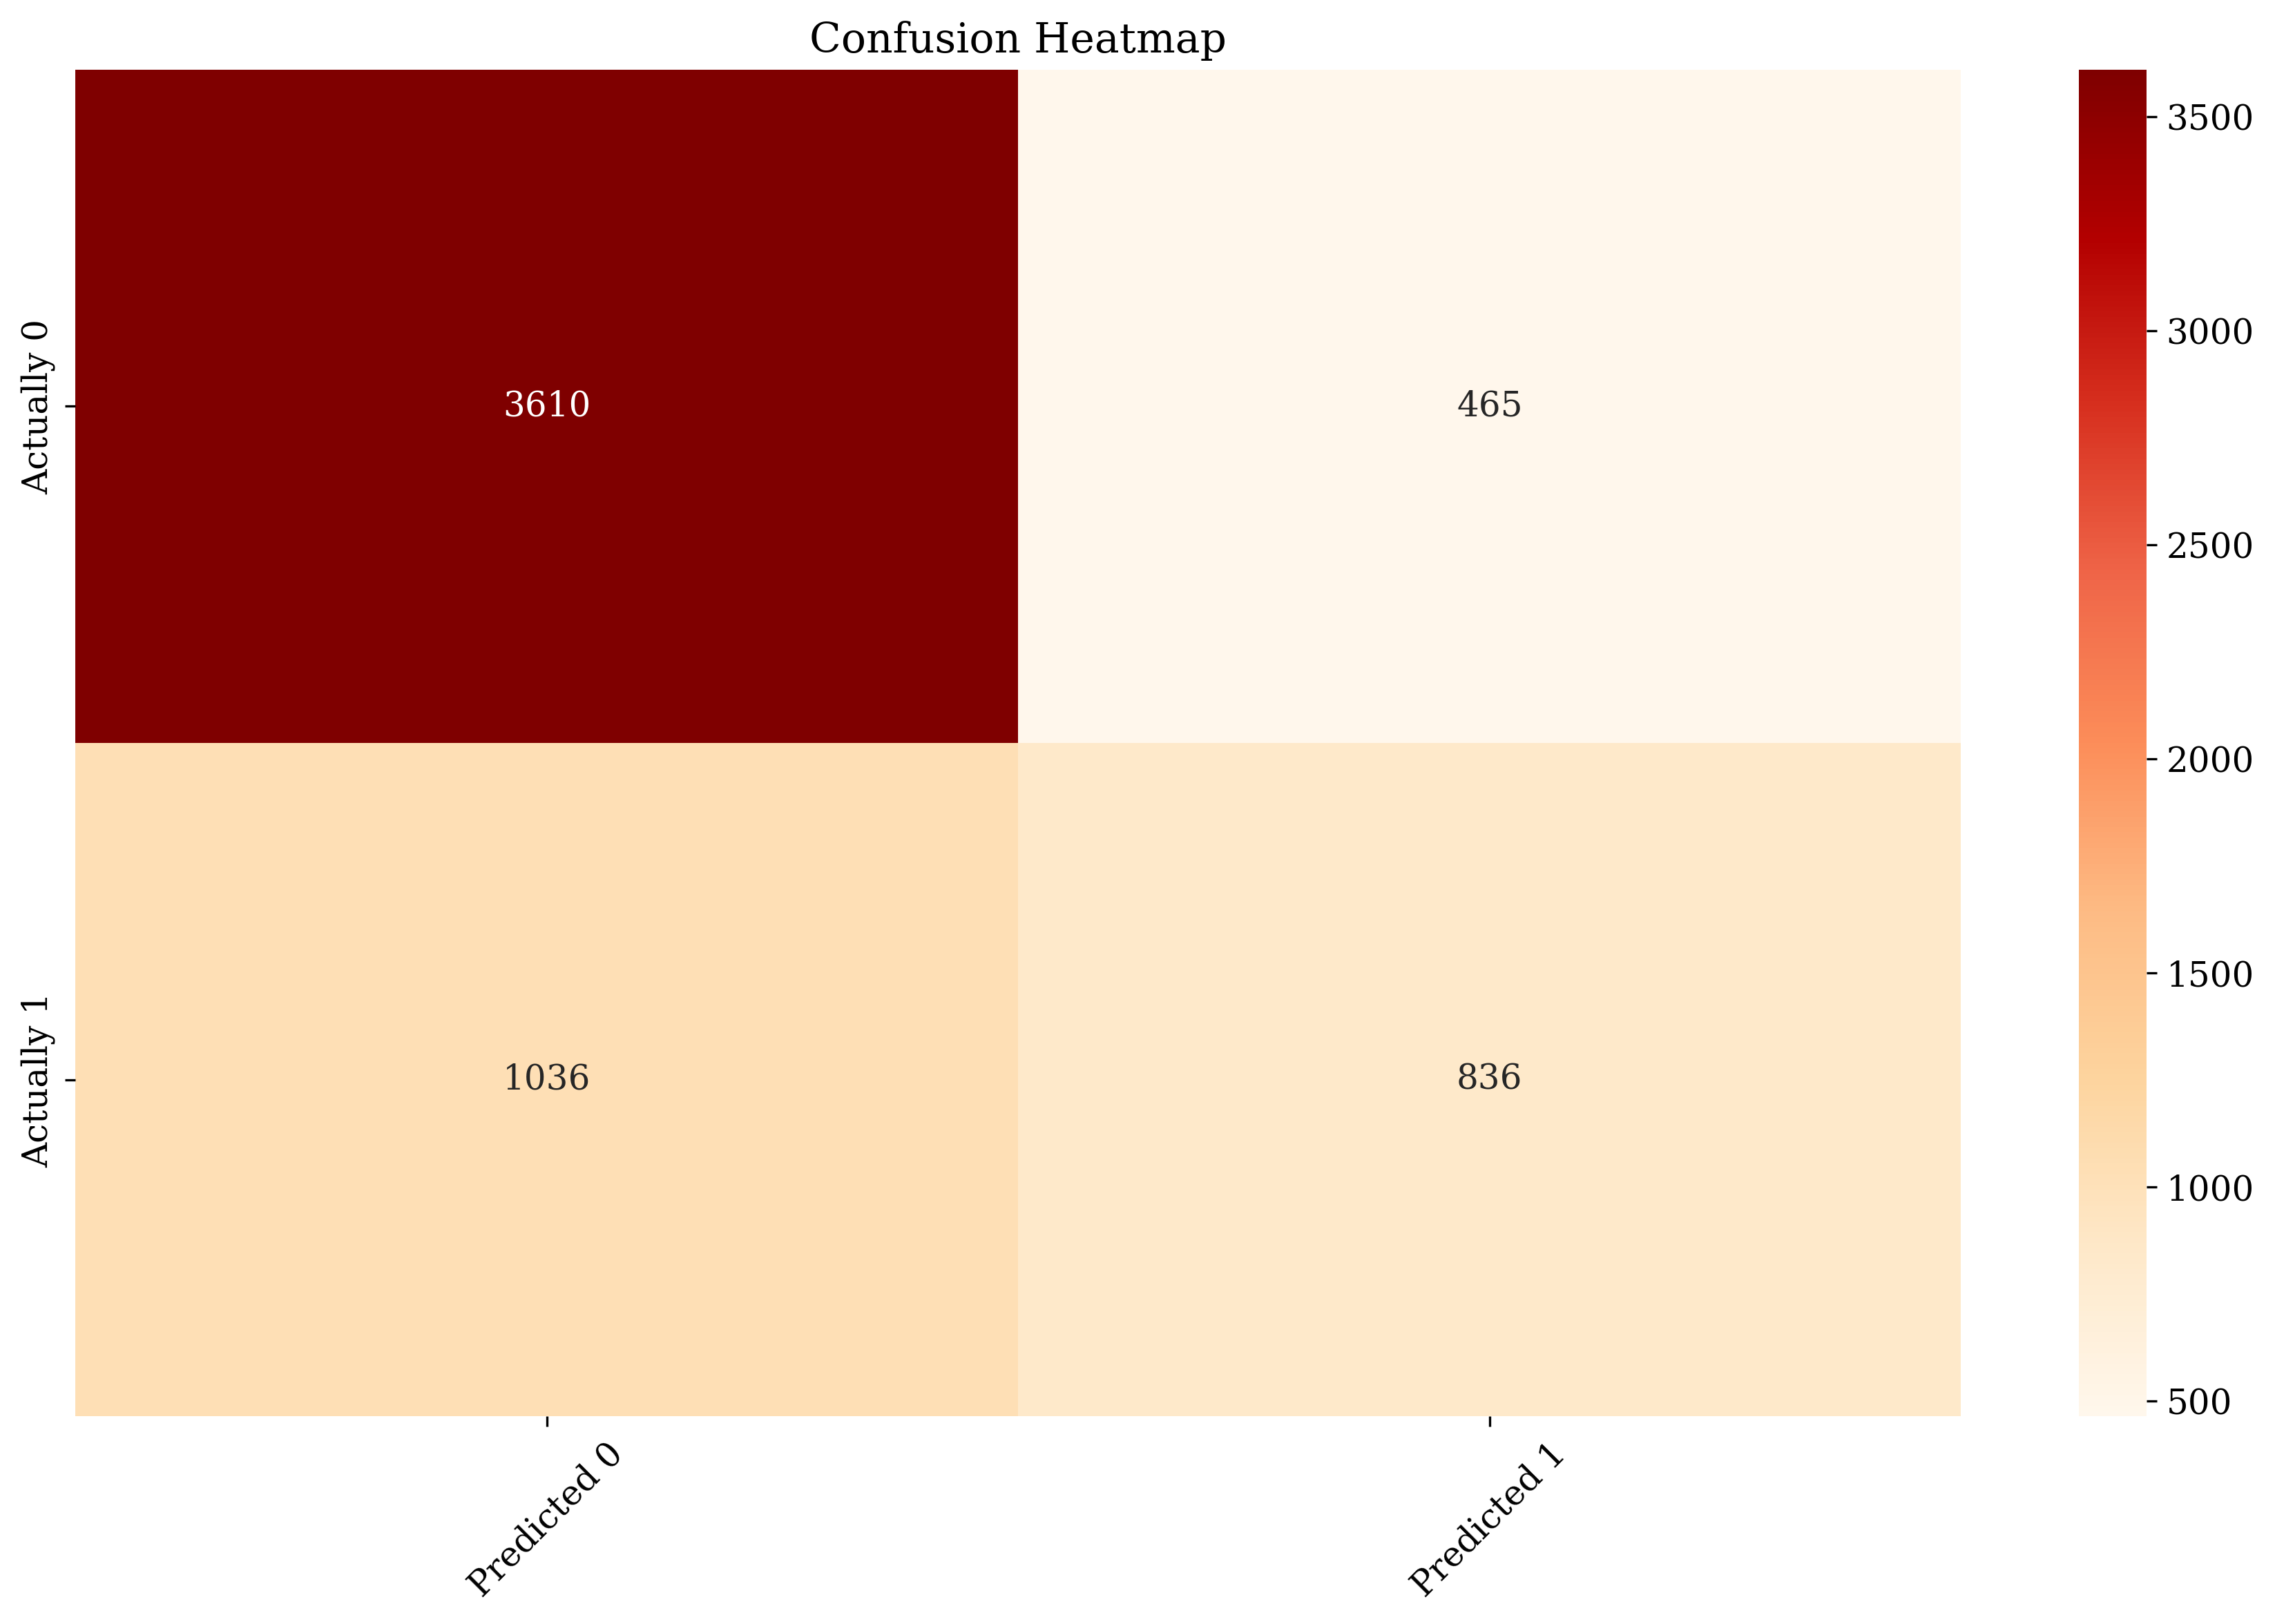

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      4075
           1       0.64      0.45      0.53      1872

    accuracy                           0.75      5947
   macro avg       0.71      0.67      0.68      5947
weighted avg       0.73      0.75      0.73      5947



In [76]:
model_utils.PlotConfusionMatrix(logit, X_test, y_test)

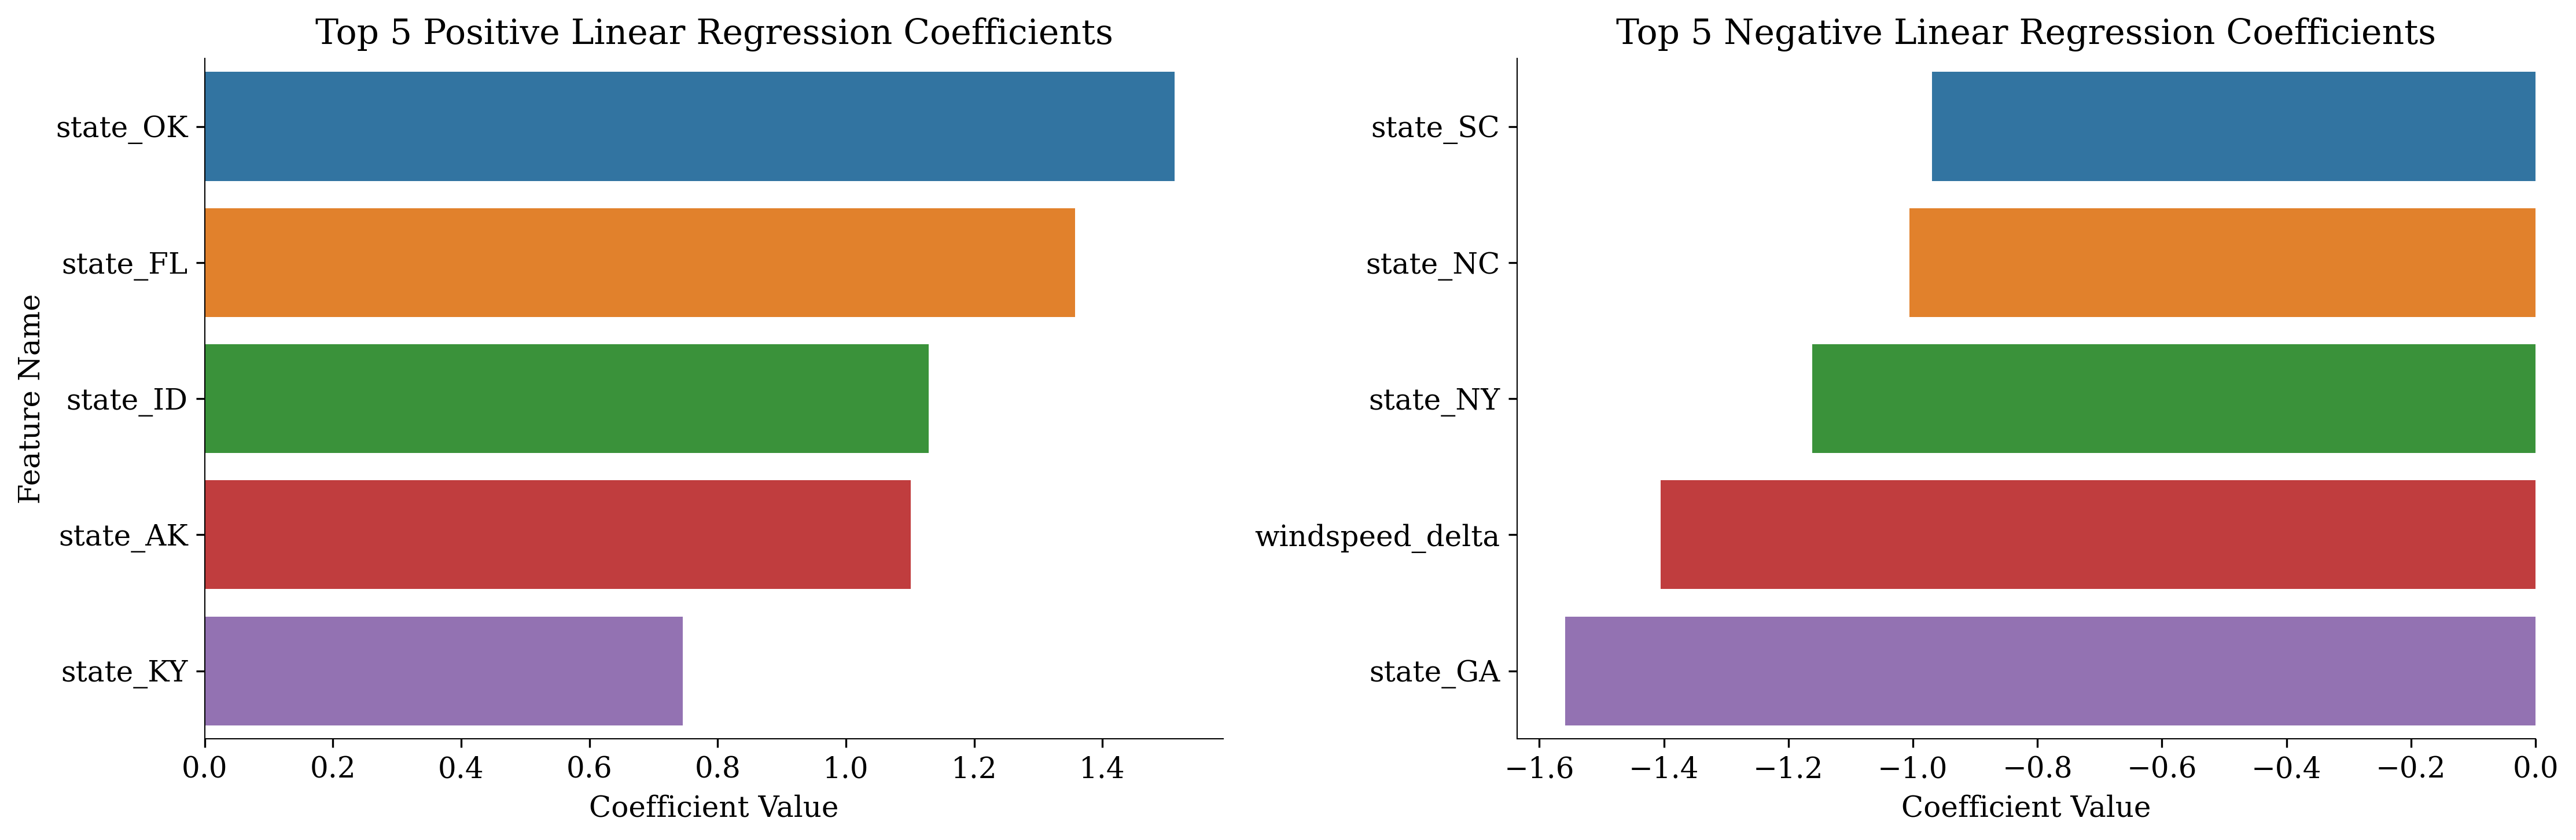

In [104]:
model_utils.PlotCoefficients(logit, X)

We can reduce the imbalance by using SMOTE

In [105]:
from imblearn.over_sampling import SMOTE

# instantiate SMOTE sampler, fit it to the training data, then resample the data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_train, y_train)

In [106]:
utils.count_percentage_df(y_train_sm)

,Count,Percentage of Total
0,16250,0.5
1,16250,0.5


In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from tempfile import mkdtemp

# Create cache
cachedir = mkdtemp()

estimators = [('reduce_dim', PCA()),
              ('logreg', LogisticRegression())]

pipe = Pipeline(estimators, memory=cachedir)

param_grid = [
    {
        'reduce_dim': [PCA(), PCA(n_components=0.9), None], 
        'logreg__penalty': ['l1', 'l2'], 
        'logreg__C': [10**x for x in range(-5, 2)],
        'logreg__solver': ['lbfgs', 'liblinear']
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2)
logit_fittedgrid = grid.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.2s
[CV] END logreg__C=1e-05, logreg__penalty=l1, logr

[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=None; total time=   0.0s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.1s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.1s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.1s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.1s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.1s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=0.0001, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_com

[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.3s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.3s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.3s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.4s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.4s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.1s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.1s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.1s
[CV] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time

[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=lbfgs, reduce_dim=None; total time=   0.3s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.4s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.4s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.4s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.5s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.8s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.1s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=0.01, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); tota

[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=liblinear, reduce_dim=None; total time=   0.3s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=1, logreg__penalty=

[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(); total time=   0.2s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END logreg__C=10, logreg__penalty=l1, logreg__solver=liblinear, reduce_dim=PCA(n_co

In [111]:
fittedgrid.best_params_

{'logreg__C': 10,
 'logreg__penalty': 'l2',
 'logreg__solver': 'liblinear',
 'reduce_dim': PCA()}

In [110]:
fittedgrid.score(X_test, y_test)

0.6995123591726922

Decision Tree

In [112]:
X, y = create_x_y(df_categorical_processed)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

In [115]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)
dt_model.fit(X_train, y_train)

dt_model.score(X_test, y_test)

0.7467630738187321

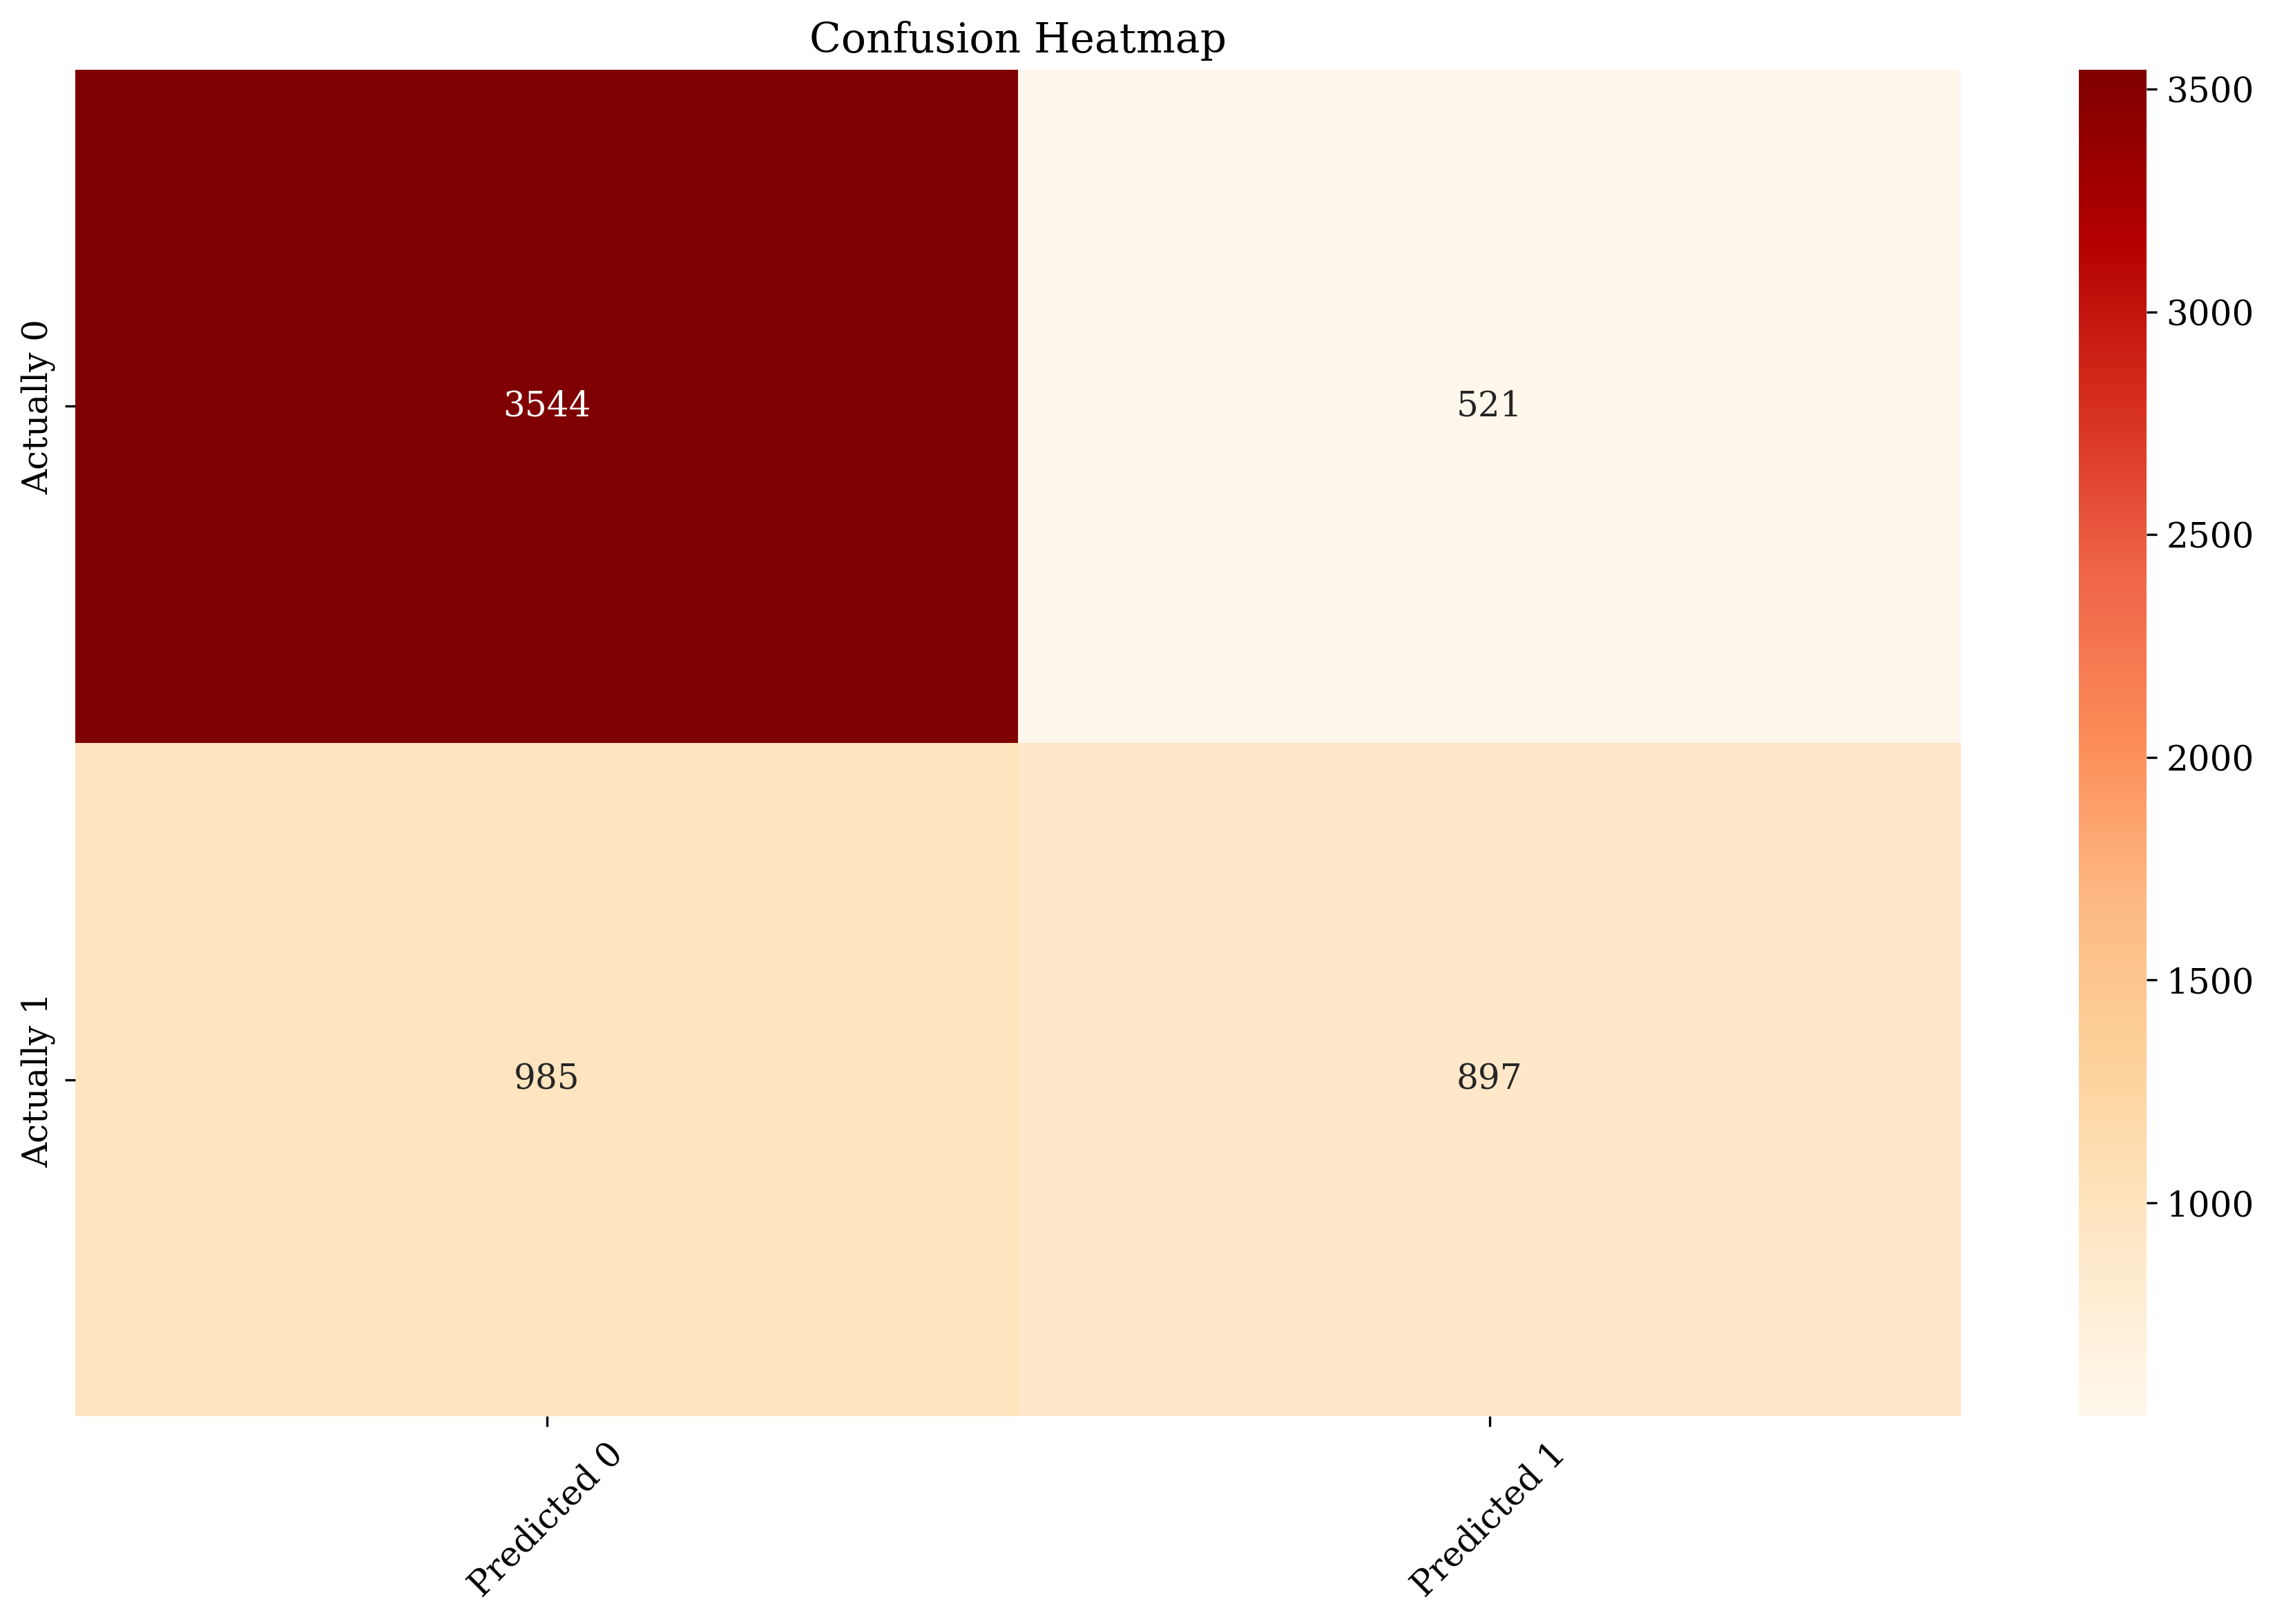

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      4065
           1       0.63      0.48      0.54      1882

    accuracy                           0.75      5947
   macro avg       0.71      0.67      0.68      5947
weighted avg       0.74      0.75      0.74      5947



In [116]:
model_utils.PlotConfusionMatrix(dt_model, X_test, y_test)

In [118]:
importances = dt_model.tree_.compute_feature_importances(normalize=False)
importances_df = pd.DataFrame({'Variable': X.columns,
                               'Importance': importances})
importances_df.sort_values(by='Importance', ascending=False)

,Variable,Importance
3,LONGITUDE,0.049338
2,LATITUDE,0.024516
6,avg_humidity,0.008823
35,state_CA,0.005789
67,state_OK,0.004484
...,...,...
46,state_IN,0.000000
47,state_KS,0.000000
49,state_LA,0.000000
50,state_MA,0.000000


In [119]:
cachedir = mkdtemp()

estimators = [('reduce_dim', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators, memory=cachedir)

param_grid = [{'reduce_dim': [PCA(), PCA(n_components=0.9), None], 
               'model__max_depth': [3, 4, 5, 6, 7, 8, 9],
               'model__criterion': ['gini', 'entropy'],
               'model__splitter': ['best', 'random'],
               'model__min_samples_leaf': list(range(2, 20, 2))}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2)
dt_fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 756 candidates, totalling 3780 fits
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(n_components=0.9); total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2, model__splitt

[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[C

[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.4s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.4s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.4s
[CV] END model__criterion=g

[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.4s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.4s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.4s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.4s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.4s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(n_components=0.9); total time=   

[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.5s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.4s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.4s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.4s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END m

[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, 

[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, 

[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion

[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion

[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gi

[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini,

[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=g

[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterio

[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterio

[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=gin

[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=gin

[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criter

[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criter

[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterio

[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=gin

[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=g

[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criter

[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criter

[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterion=gin

[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   1.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   1.0s
[CV] END model__criterion=gin

[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   1.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   1.0s
[CV] END model__criter

[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   1.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   1.0s
[CV] END model__criter

[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   1.2s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterio

[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=4, model__splitter=random, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END mo

[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterion=g

[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criter

[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=16, model__splitter=random, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=gini, model__max_depth=9, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV]

[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(n_components=0.9); total time=   0

[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END mo

[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(n_components

[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.6s
[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(n_components=0.9); total ti

[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.7s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(n_components=0.9); total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(n_components=0.9); 

[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END mo

[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] E

[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV]

[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   0.8s
[CV]

[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END m

[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END m

[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV

[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   0.9s
[CV

[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] EN

[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END

[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] E

[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[

[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   1.1s
[

[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   1.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   1.2s
[CV] END

[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   1.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   1.2s
[CV] END

[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   1.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   1.2s
[

[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   1.2s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   1.2s
[

[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   1.4s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2, model__splitter=best, reduce_dim=PCA(); total time=   1.4s
[CV

[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   1.4s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=6, model__splitter=best, reduce_dim=PCA(); total time=   1.4s
[CV] END

[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=8, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   1.4s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=10, model__splitter=best, reduce_dim=PCA(); total time=   1.4s
[CV] E

[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=12, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   1.4s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=14, model__splitter=best, reduce_dim=PCA(); total time=   1.4s
[

[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=16, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   1.4s
[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=18, model__splitter=best, reduce_dim=PCA(); total time=   1.4s
[

[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=2, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   1.5s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=4, model__splitter=best, reduce_dim=PCA(); total time=   1.5s
[CV] END

[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=6, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   1.5s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=8, model__splitter=best, reduce_dim=PCA(); total time=   1.5s
[CV] END

[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=10, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   1.5s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=12, model__splitter=best, reduce_dim=PCA(); total time=   1.4s
[

[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=14, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   1.5s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=16, model__splitter=best, reduce_dim=PCA(); total time=   1.4s
[

[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=9, model__min_samples_leaf=18, model__splitter=random, reduce_dim=None; total time=   0.0s


In [121]:
dt_fittedgrid.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 8,
 'model__min_samples_leaf': 16,
 'model__splitter': 'best',
 'reduce_dim': None}

In [120]:
dt_fittedgrid.score(X_test, y_test)

0.7546662182613082

## Ensemble method

In [123]:
from xgboost import XGBClassifier

xgboost = XGBClassifier(objective='multi:softmax', num_class=2, eval_metric='mlogloss', max_depth=8)
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_class=2, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, ...)

In [124]:
xgboost.score(X_test, y_test)

0.8000672608037666

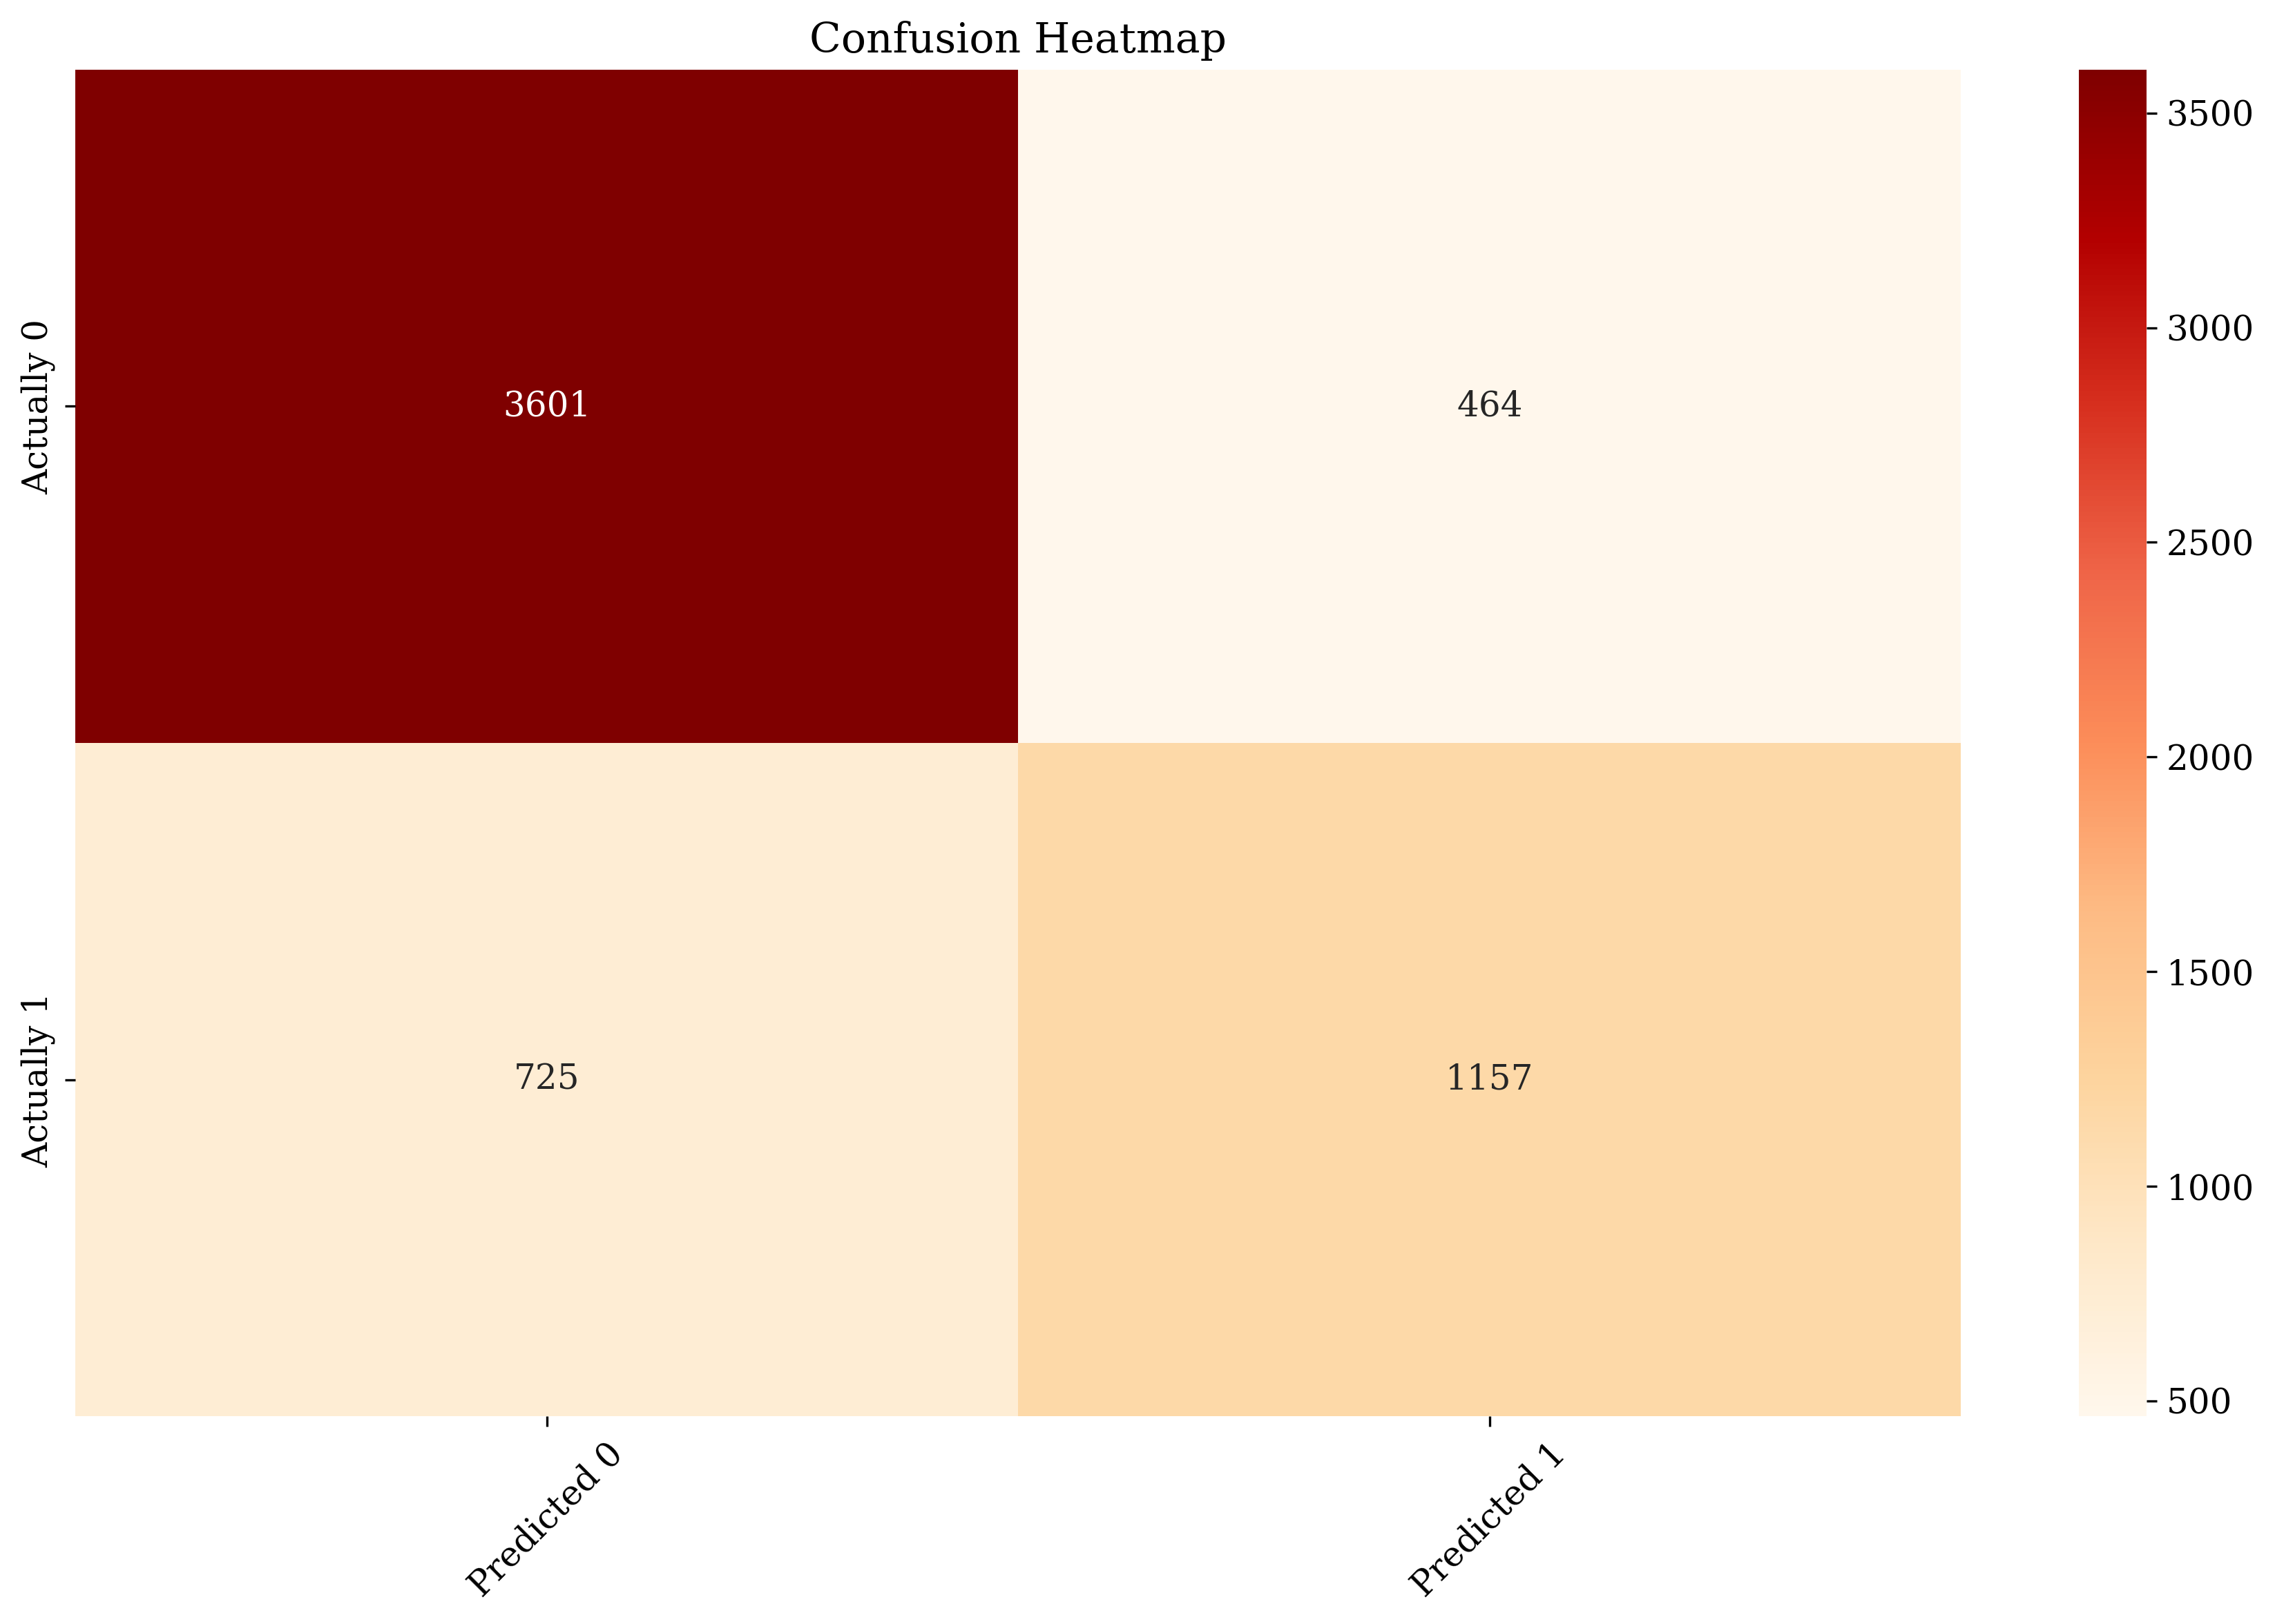

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4065
           1       0.71      0.61      0.66      1882

    accuracy                           0.80      5947
   macro avg       0.77      0.75      0.76      5947
weighted avg       0.79      0.80      0.80      5947



In [125]:
model_utils.PlotConfusionMatrix(xgboost, X_test, y_test)